# Optional exercise 

This is just some simple statistics and data wrangling based on current events. Purely optional!

## Bayes theorem 

The following graphic was shown by a German talk show presenter on November 10, 2021:  

<img src="https://pbs.twimg.com/media/FELYFI8XsAoouxu?format=png&name=small">

It was implied that the graph shows that "the vaccine is not as efficient as previously thought" for people over 60. Using (relatively) basic statistics (and maybe one line of python code), show that the vaccine *does* have a very high efficacy at preventing getting the disease, hospitalisation, and death. You can do this by comparing the probability of getting the decease while vaccinated $P(D|V)$ to the probability of getting the decease while non-vaccinated $P(D|NV)$.

In [1]:
import pandas as pd
df = pd.DataFrame([91, 60, 45, 34, 43], columns=['V'], 
                  index=['All', 'Infections', 'Hospitalization', 'ICU', 'Death'])
df['NV'] = 100 - df['V']

print('Chance of getting X while non-vaccinated over being vaccinated:')
df['NV'] / df['V'] * df.iloc[0].V / df.iloc[0].NV

Chance of getting X while non-vaccinated over being vaccinated:


All                 1.000000
Infections          6.740741
Hospitalization    12.358025
ICU                19.627451
Death              13.403101
dtype: float64

## Difference between the 2020 and 2021 autumn COVID waves in Austria

[Our World in Data](https://ourworldindata.org) is a website from the University of Oxford providing all kinds of statistics, from climate change to pandemics to meat consumption per capita. Based on current events, let's use the data they provide to draw the following plot: "Incidence in Austria since October 1st, in 2020 and 2021" (two curves). Repeat with Hospitalisations and Deaths.

Here is a link to the data: https://covid.ourworldindata.org/data/owid-covid-data.csv

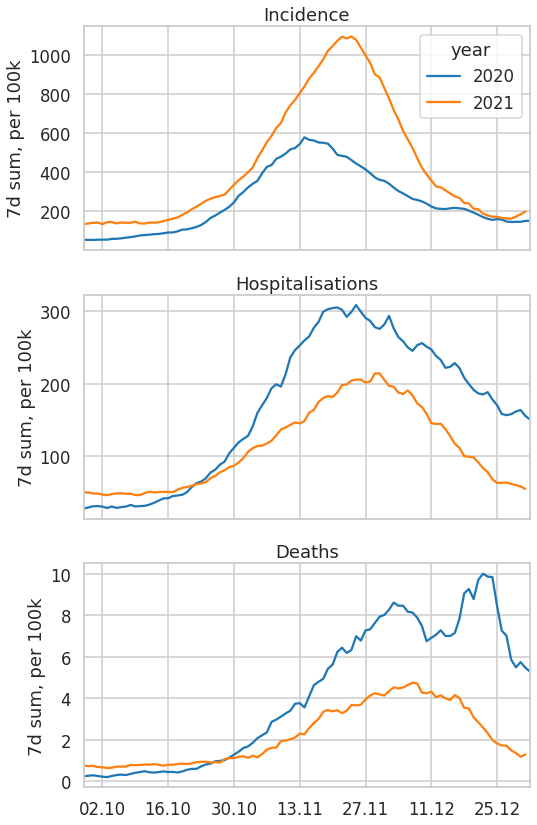

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
# Just to make the plots look different
import seaborn as sns
sns.set_context('talk')
sns.set_style('whitegrid')

# Read the data
url = 'https://covid.ourworldindata.org/data/owid-covid-data.csv'
odf = pd.read_csv(url, index_col='date', parse_dates=True)

# Pick only the data till 2022
odf = odf.loc[:'2021']

# Select country and parse day of year for time axis
df = odf.loc[odf.location == 'Austria'].copy()
df['year'] = df.index.year
df['doy'] = df.index.dayofyear

# Plot
f, axs = plt.subplots(3, 1, figsize=(8, 14), sharex=True)

values = ['new_cases_smoothed_per_million',
          'hosp_patients_per_million',
          'new_deaths_smoothed_per_million']
titles = ['Incidence', 'Hospitalisations', 'Deaths']
for ax, y, t in zip(axs, values, titles):

    # Som pandas magic
    cases = df.pivot(index='doy', columns='year', values=y)
    cases = cases * 7 / 10  # inzidenz
    # Naive date and plot
    cases['date'] = pd.to_datetime(cases.index, format='%j')
    cases.set_index('date').iloc[270:].plot(ax=ax, legend=ax is axs[0])

    # Replace day of year with real date
    ax.xaxis.clear()
    date_form = DateFormatter("%d.%m")
    ax.xaxis.set_major_formatter(date_form)
    ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=2))
    ax.set_ylabel('7d sum, per 100k'); ax.set_title(t);

## Exponential curve explained to our neighbors 

Use the same data to draw the incidence curves in Austria, Germany, and Switzerland (the three countries [with the lowest vaccination rate in Western Europe](https://www.ft.com/content/f04ac67b-92e4-4bab-8c23-817cc0483df5)) since October 1st. This plot hides an important difference: the waves have started later in Germany and Switzerland than they have in Austria. Therefore, plot instead the incidence curves as a function of "days since the incidence reached 180" to compare the waves in each country. 

Reminder, the "incidence" is the number of positive cases per 100k inhabitants over 7 days. In the table, it is computed by multiplying `new_cases_smoothed_per_million` with `7 / 10`.

Austria 2021-10-19 00:00:00
Germany 2021-11-04 00:00:00
Switzerland 2021-11-08 00:00:00


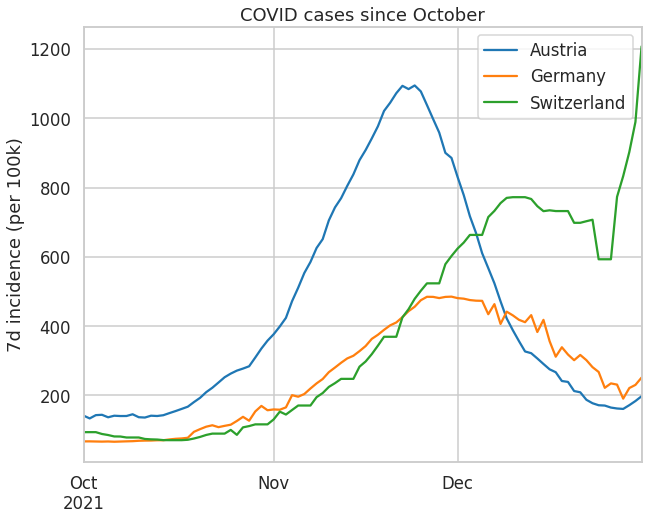

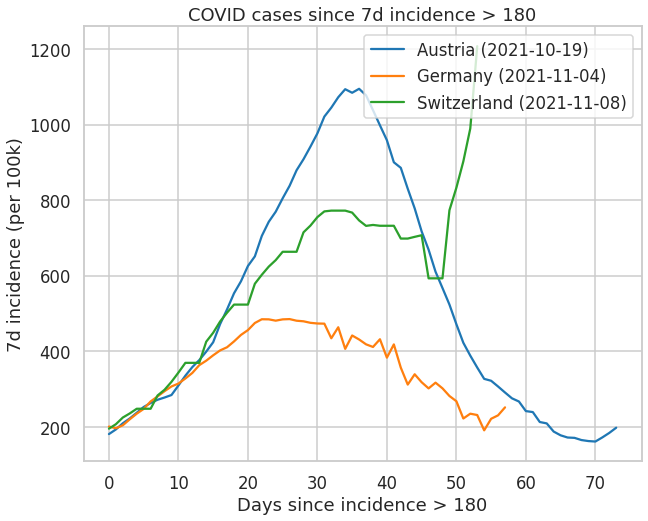

In [2]:
odf = odf.reset_index()

# Some pandas magic here
df = odf.groupby(['location', 'date'])['new_cases_smoothed_per_million'].sum()
df = df.unstack(level=0).rename_axis("", axis=1) * 7 / 10

f, ax = plt.subplots(1, 1, figsize=(10, 8))
df.loc['2021/10':][['Austria', 'Germany', 'Switzerland']].plot(ax=ax);
ax.set_xlabel('');
ax.set_ylabel('7d incidence (per 100k)');
ax.set_title('COVID cases since October');

ids = (df.loc['2021/10':][['Austria', 'Germany', 'Switzerland']] >= 180).idxmax()

tdf = pd.DataFrame()
for k, d in ids.items():
    tdf[k + d.strftime(' (%Y-%m-%d)')] = pd.Series(df[k].loc[d:].values)
    print(k, d)

f, ax = plt.subplots(1, 1, figsize=(10, 8))
tdf.plot(ax=ax);
ax.set_xlabel('Days since incidence > 180');
ax.set_ylabel('7d incidence (per 100k)');
ax.set_title('COVID cases since 7d incidence > 180');